In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img


from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import sys
import os

from IPython.display import display, clear_output
pd.set_option('display.max_colwidth', None)

2023-01-19 19:36:27.318497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 19:36:27.670364: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jiehui/anaconda3/envs/tensorflow/lib/python3.9/site-packages/cv2/../../lib64:/home/jiehui/test_ws/devel/lib:/opt/ros/melodic/lib
2023-01-19 19:36:27.670389: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-19 19:36:28.644742: W tensorflow/compiler/xla/stream_executor/platform/default/dso_

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-01-19 19:36:30.633200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 19:36:30.633430: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jiehui/anaconda3/envs/tensorflow/lib/python3.9/site-packages/cv2/../../lib64:/home/jiehui/test_ws/devel/lib:/opt/ros/melodic/lib
2023-01-19 19:36:30.633523: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jiehui/anaconda3/envs/tensorflow/lib/python3.9/site-packages/cv2/../../lib64:/home/jiehui/test_ws/devel/lib:

# Get the data and store the directories in dataframe

In [8]:
def plot_data_distribution(file_directory_df, additional_text):
    plt.bar(file_directory_df['class'].value_counts().index, file_directory_df['class'].value_counts())
    plt.title("Data Distribution" + " (" + additional_text + ")")


In [9]:
def get_data_file_directories(data_directory):
    file_directory_dict = {
    "class":[],
    "directory":[]
    }

    for root, dirs, files in os.walk(data_directory, topdown=False):
        for name in files:
            file_directory_dict['class'].append(root.split("/")[-1])
            file_directory_dict['directory'].append(os.path.join(root, name))

    file_directory_df = pd.DataFrame(file_directory_dict)

    return file_directory_df

In [10]:
def get_num_of_augmentation_for_each_class(file_directory_df, num_of_images_for_each_class):
    num_of_augmentation_for_each_class = {}
    for object_class in file_directory_df['class'].unique():
        num_of_images_for_class = len(file_directory_df.loc[file_directory_df['class'] == object_class])
        num_of_augmentation_for_each_class[object_class] = num_of_images_for_each_class // num_of_images_for_class

    return num_of_augmentation_for_each_class

In [11]:
def generate_augmentations_for_each_class(num_of_augmentation_for_each_class, file_directory_df):
    # Create the augmentation generator
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        shear_range=0.2,
        horizontal_flip=True,
        rotation_range=40, fill_mode='nearest',
        channel_shift_range = 10,
        zoom_range=0.1,
        )
    
    # Augmented Training Data Folder
    directory_path = file_directory_df['directory'][0].rsplit('/', 3)[0] + '/augmented_training_data'
    
    # Augmented Training Data Folder for each class
    directory_path_for_each_class = {}
    # For each class
    for object_class in num_of_augmentation_for_each_class.keys():
        
        # Create the folder path and add to dictionary
        object_directory_path = directory_path + '/' + object_class
        directory_path_for_each_class[object_class] = object_directory_path
        
        # If folder not created, create it
        if not (os.path.exists(object_directory_path)):
            os.makedirs(object_directory_path)

    row_num = 0
    # For each picture in the training data, generate the augmentations
    for index, row in file_directory_df.iterrows():
        
        object_class = row['class']
        object_filepath = row['directory']

        original_image = plt.imread(object_filepath)
        expanded_image = np.expand_dims(original_image, 0)

        datagen.fit(expanded_image)
        for i in zip(datagen.flow(expanded_image,                    #image we chose
                save_to_dir=directory_path_for_each_class[object_class],     #this is where we figure out where to save
                save_prefix='aug',              # it will save the images as 'aug_0912' some number for every new augmented image
                save_format='png', batch_size=10), range(num_of_augmentation_for_each_class[object_class])) :     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
                pass
        
        row_num += 1
        clear_output(wait=True)
        print("Augmenting: " + str(row_num) + " of " + str(len(file_directory_df)))

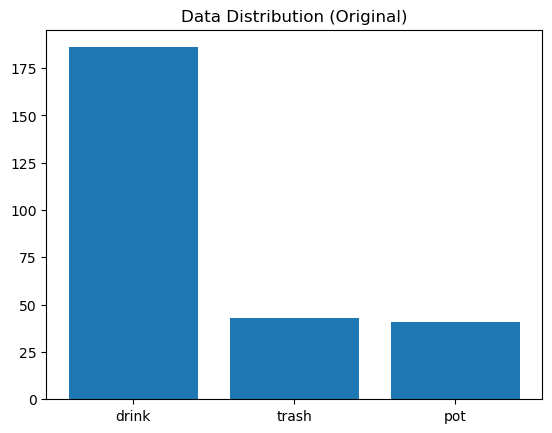

In [12]:
cwd = os.getcwd()
data_directory = cwd+"/training_data"

original_training_data_file_directory_df = get_data_file_directories(data_directory)
plot_data_distribution(original_training_data_file_directory_df, "Original")

In [13]:
num_augmentations = 10
class_with_highest_num = original_training_data_file_directory_df['class'].value_counts().index[0]
num_of_images_for_each_class = len(original_training_data_file_directory_df.loc[original_training_data_file_directory_df['class'] == class_with_highest_num]) * num_augmentations
num_of_augmentation_for_each_class = get_num_of_augmentation_for_each_class(original_training_data_file_directory_df, num_of_images_for_each_class)
generate_augmentations_for_each_class(num_of_augmentation_for_each_class, original_training_data_file_directory_df)

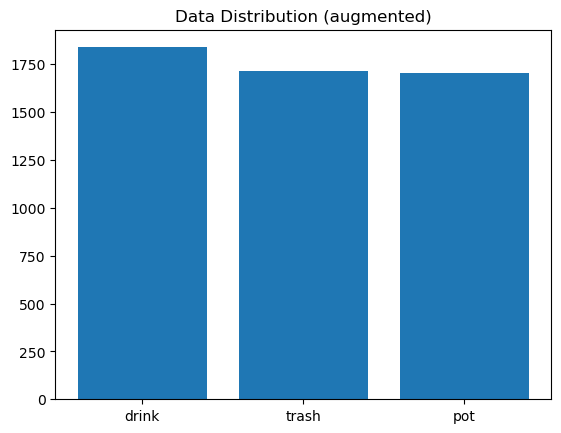

In [14]:
augmented_data_directory = cwd+"/augmented_training_data"
augmented_training_data_file_directory_df = get_data_file_directories(augmented_data_directory)
plot_data_distribution(augmented_training_data_file_directory_df, "augmented")

In [15]:
augmented_training_data_file_directory_df

,class,directory
0,pot,/home/jiehui/image_classification_with_CNNKeras/augmented_training_data/pot/aug_0_1232.png
1,pot,/home/jiehui/image_classification_with_CNNKeras/augmented_training_data/pot/aug_0_6682.png
2,pot,/home/jiehui/image_classification_with_CNNKeras/augmented_training_data/pot/aug_0_2214.png
3,pot,/home/jiehui/image_classification_with_CNNKeras/augmented_training_data/pot/aug_0_9036.png
4,pot,/home/jiehui/image_classification_with_CNNKeras/augmented_training_data/pot/aug_0_1980.png
...,...,...
5254,trash,/home/jiehui/image_classification_with_CNNKeras/augmented_training_data/trash/aug_0_1761.png
5255,trash,/home/jiehui/image_classification_with_CNNKeras/augmented_training_data/trash/aug_0_498.png
5256,trash,/home/jiehui/image_classification_with_CNNKeras/augmented_training_data/trash/aug_0_1188.png
5257,trash,/home/jiehui/image_classification_with_CNNKeras/augmented_training_data/trash/aug_0_6700.png


In [21]:
image_size = (180, 180)
batch_size = 8

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    augmented_data_directory,
    validation_split=0.2,
    subset="both",
    seed=5000,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5259 files belonging to 3 classes.
Using 4208 files for training.
Using 1051 files for validation.


In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

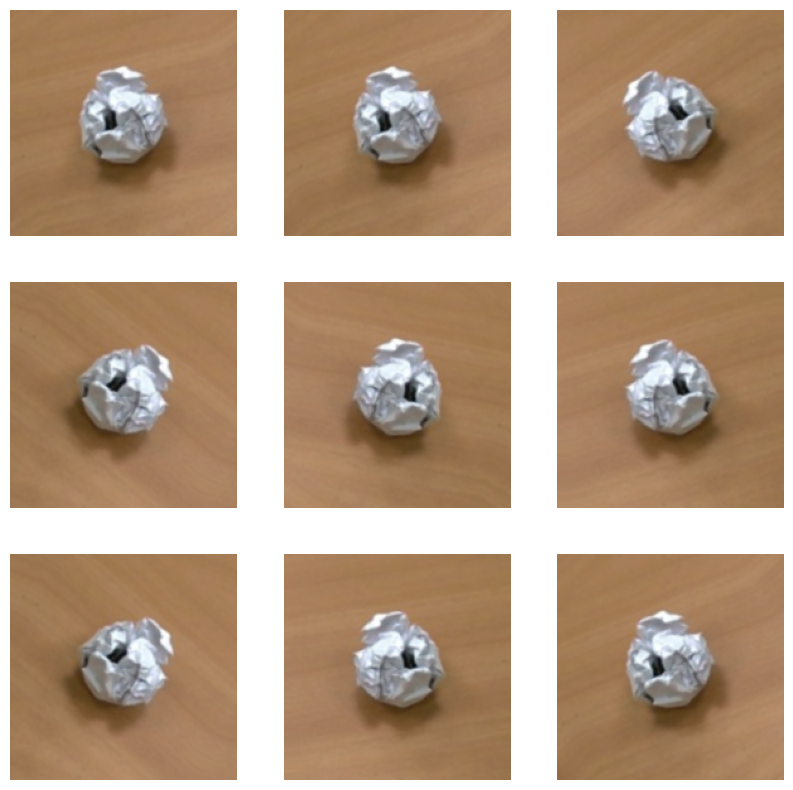

In [66]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [67]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [68]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Num Classes: 3


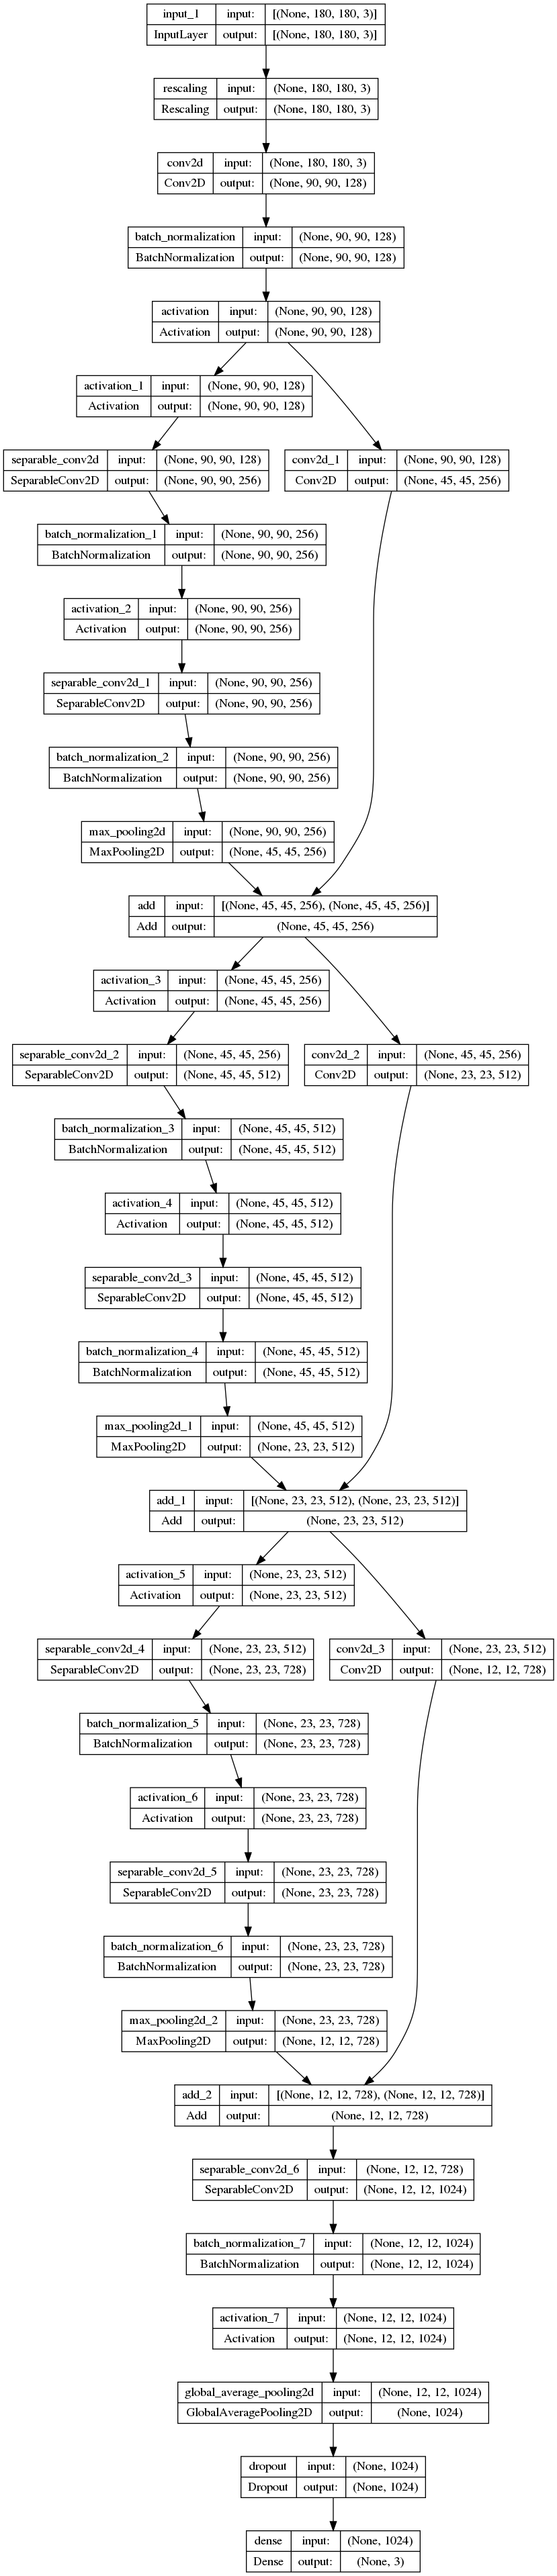

In [69]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        print("Num Classes: " + str(num_classes))
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=len(num_of_augmentation_for_each_class))
keras.utils.plot_model(model, show_shapes=True)

In [70]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/5
526/526 [==============================] - 829s 2s/step - loss: 0.2781 - accuracy: 0.9064 - val_loss: 0.8372 - val_accuracy: 0.6223
Epoch 2/5
526/526 [==============================] - 828s 2s/step - loss: 0.1270 - accuracy: 0.9615 - val_loss: 0.0497 - val_accuracy: 0.9772
Epoch 3/5
526/526 [==============================] - 829s 2s/step - loss: 0.0880 - accuracy: 0.9729 - val_loss: 0.0508 - val_accuracy: 0.9895
Epoch 4/5
526/526 [==============================] - 828s 2s/step - loss: 0.0524 - accuracy: 0.9850 - val_loss: 0.0414 - val_accuracy: 0.9905
Epoch 5/5
526/526 [==============================] - 831s 2s/step - loss: 0.0750 - accuracy: 0.9758 - val_loss: 0.0026 - val_accuracy: 0.9990


In [51]:
tf.saved_model.save(model, cwd+"\SavedModel")

INFO:tensorflow:Assets written to: /home/jiehui/image_classification_with_CNNKeras\SavedModel/assets


INFO:tensorflow:Assets written to: /home/jiehui/image_classification_with_CNNKeras\SavedModel/assets


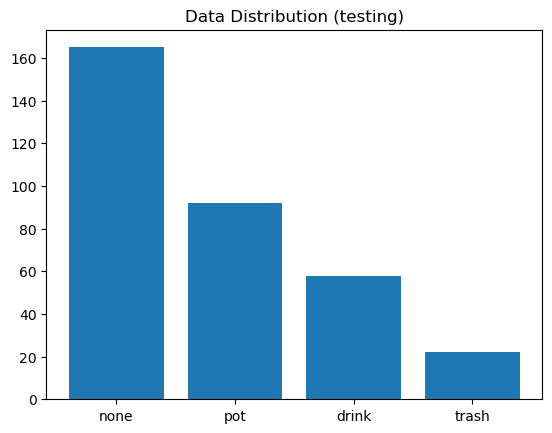

In [52]:
testing_data_directory = cwd+"/testing_data"
testing_data_file_directory_df = get_data_file_directories(testing_data_directory)
plot_data_distribution(testing_data_file_directory_df, "testing")

In [53]:
def convert_to_keras_array(img_directory):
    img = keras.preprocessing.image.load_img(
        img_directory, target_size=image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis

    return img_array

In [54]:
def extract_prediction(predictions):
    class_array = ['drink', 'pot', 'trash']
    
    predicted_class_num = np.argmax(predictions)
    
    return class_array[predicted_class_num], predictions[0][predicted_class_num]

def make_prediction(img_directory):
    predictions = model.predict(convert_to_keras_array(img_directory))

    return extract_prediction(predictions)

In [55]:
model = keras.models.load_model("SavedModel")

In [56]:
testing_data_file_directory_df['predicted_class'],  testing_data_file_directory_df['confidence'] = zip(*testing_data_file_directory_df['directory'].apply(make_prediction))

1/1 [==============================] - 0s 63ms/step


In [59]:
predictions_df_array = {}
for object_class in testing_data_file_directory_df['class'].unique():
    object_df = testing_data_file_directory_df.loc[testing_data_file_directory_df['class'] == object_class]
    
    if object_class != 'none':
        misclassified_df = object_df.loc[testing_data_file_directory_df['class'] != testing_data_file_directory_df['predicted_class']]
        classified_df = object_df.loc[testing_data_file_directory_df['class'] == testing_data_file_directory_df['predicted_class']]
    else:
        classified_df = object_df.loc[testing_data_file_directory_df['confidence'] < 0.7]
        misclassified_df = object_df.loc[testing_data_file_directory_df['confidence'] > 0.7]

    predictions_df_array[object_class] = [classified_df, misclassified_df]

In [60]:
accuracy = {}
for object_class in testing_data_file_directory_df['class'].unique():
    accuracy[object_class] = len(predictions_df_array[object_class][0])/(len(predictions_df_array[object_class][0])+len(predictions_df_array[object_class][1]))

In [61]:
accuracy

{'pot': 0.8369565217391305,
 'drink': 1.0,
 'none': 0.15151515151515152,
 'trash': 1.0}

In [62]:
object_class = 'pot'
predictions_df_array[object_class][0].loc[predictions_df_array[object_class][0]['confidence'] < 0.8]

,class,directory,predicted_class,confidence
0,pot,/home/jiehui/image_classification_with_CNNKeras/testing_data/pot/310.jpg,pot,0.532757
8,pot,/home/jiehui/image_classification_with_CNNKeras/testing_data/pot/309.jpg,pot,0.554676
9,pot,/home/jiehui/image_classification_with_CNNKeras/testing_data/pot/312.jpg,pot,0.663550
14,pot,/home/jiehui/image_classification_with_CNNKeras/testing_data/pot/295.jpg,pot,0.731268
23,pot,/home/jiehui/image_classification_with_CNNKeras/testing_data/pot/291.jpg,pot,0.633870
51,pot,/home/jiehui/image_classification_with_CNNKeras/testing_data/pot/270.jpg,pot,0.709139
52,pot,/home/jiehui/image_classification_with_CNNKeras/testing_data/pot/247.jpg,pot,0.796484
54,pot,/home/jiehui/image_classification_with_CNNKeras/testing_data/pot/294.jpg,pot,0.717336
59,pot,/home/jiehui/image_classification_with_CNNKeras/testing_data/pot/268.jpg,pot,0.700662
60,pot,/home/jiehui/image_classification_with_CNNKeras/testing_data/pot/296.jpg,pot,0.781752


In [66]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

loaded = keras.models.load_model("SavedModel")
infer = loaded.signatures['serving_default']

f = tf.function(infer).get_concrete_function(input_1=tf.TensorSpec(shape=[None, 180, 180, 3], dtype=tf.float32))
f2 = convert_variables_to_constants_v2(f)
graph_def = f2.graph.as_graph_def()

# Export frozen graph
with tf.io.gfile.GFile('frozen_graph.pb', 'wb') as f:
   f.write(graph_def.SerializeToString())

2023-01-19 20:02:01.118760: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 20:02:01.118868: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-01-19 20:02:01.118946: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-01-19 20:02:01.119508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 20:02:01.119602: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

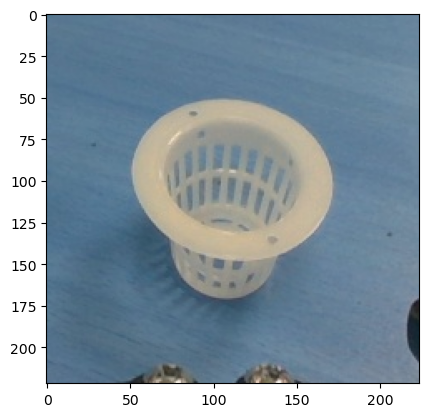

In [74]:
plt.imshow(input_img)

In [63]:
import cv2

In [85]:
# read frozen graph with OpenCV API
model_opencv = cv2.dnn.readNetFromTensorflow(cwd + "/frozen_graph.pb")
# get preprocessed image
input_img = cv2.imread(testing_data_file_directory_df['directory'][0])
print(input_img.shape)
print(model_opencv.getParam)
blob = cv2.dnn.blobFromImage(image=input_img, scalefactor=0.01, size=(180, 180))

model_opencv.setInput(blob)
outputs = model_opencv.forward()

(222, 224, 3)
<built-in method getParam of cv2.dnn.Net object at 0x7f44945d0f10>


error: OpenCV(4.7.0) /io/opencv/modules/dnn/src/net.cpp:79: error: (-215:Assertion failed) !empty() in function 'forward'
